In [1]:
import os
import sys
sys.path.append("/groups/kemi/brq616/speciale/opt/xTB/tQMC/QMC")

import logging
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdMD
import hashlib
import itertools
from itertools import product
from rdkit import Chem, rdBase
import time
from tqdm import tqdm
from rdkit.Chem import rdchem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from qmconf import QMConf
from qmmol import QMMol
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
rdBase.DisableLog('rdApp.error')  # disable RDKit warning messages
# Set up logging
logging.basicConfig(level=logging.INFO)

In [3]:
def generate_molecules(base_mol, substituents, indices, max_subs, min_subs=0):
    new_mols = set()
    failed = 0
    max_possible_subs = min(max_subs, len(indices), len(substituents))
    total_subs_range = max_possible_subs + 1

    for num_subs in range(min_subs, total_subs_range):
        for subs in itertools.combinations_with_replacement(substituents, num_subs):
            for inds in itertools.combinations(indices, num_subs):
                new_mol = Chem.RWMol(base_mol)
                for (sub, sub_index, bond_type), base_index in zip(subs, inds):
                    num_atoms_new = new_mol.GetNumAtoms()
                    for atom in sub.GetAtoms():
                        new_mol.AddAtom(atom)
                    for bond in sub.GetBonds():
                        new_mol.AddBond(bond.GetBeginAtomIdx(
                        ) + num_atoms_new, bond.GetEndAtomIdx() + num_atoms_new, bond.GetBondType())
                    new_mol.AddBond(
                        base_index, num_atoms_new + sub_index, bond_type)
                try:
                    Chem.SanitizeMol(new_mol)
                    new_mols.add(new_mol)
                except:
                    failed += 1

    logging.debug(f'Failed sanitizations: {failed}')
    return new_mols


def visualize_molecule(molecule):
    if isinstance(molecule, str):
        molecule = Chem.MolFromSmiles(molecule)
    
    img = Draw.MolToImage(molecule)
    display(img)



def replace_atoms(base_smiles, atom_list, indices):
    new_mols = set()
    atom_combinations = product(atom_list, repeat=len(indices))
    
    for atom_combination in atom_combinations:
        new_smiles = base_smiles
        for idx, replacement_atom in zip(indices, atom_combination):
            new_smiles = new_smiles.replace('*', replacement_atom, 1)
        
        new_mol = Chem.MolFromSmiles(new_smiles)
        if new_mol:
            try:
                Chem.SanitizeMol(new_mol)
                new_mols.add(new_mol)
            except:
                print(f"Failed to sanitize molecule: {new_smiles}")
        else:
            print(f"Failed to create molecule: {new_smiles}")

    return new_mols


def generate_and_print_molecules(base_molecule, substituents, positions, 
                                 max_subs, ring_side, position_type):    
    all_new_molecules = set()
    logging.debug(
        f"""Generating {ring_side} ring {position_type} positions 
        with up to {max_subs} substitutions""")
    for num_subs in range(0, max_subs+1):
        new_molecules = generate_molecules(
            base_molecule, substituents, positions, num_subs)
        all_new_molecules.update(new_molecules)
    return all_new_molecules


def add_atom_numbers(molecule):
    # Add atom index property to each atom
    for atom in molecule.GetAtoms():
        atom.SetProp('molAtomMapNumber', str(atom.GetIdx()))


def validate_molecules(molecule_tuples):
    invalid_molecules = []
    for (mol, index, bond) in molecule_tuples:
        if mol is None:
            invalid_molecules.append((mol, index, bond))
    return invalid_molecules


def get_hashed_label(smiles, length=10):
    if smiles is not None:
        hashed_label = hashlib.sha1(smiles.encode()).hexdigest()[:length]
        return hashed_label
    else:
        return None

class MoleculeSet:
    def __init__(self):
        self._molecules = set()
        
    def smiles(self):
        for smiles_str in self._molecules:
            yield smiles_str
    
    def update_with_canonical_smiles(self, new_molecules):
        canonical_smiles = {Chem.MolToSmiles(mol, canonical=True) for mol in new_molecules}
        self._molecules.update(canonical_smiles)

    def __len__(self):
        return len(self._molecules)

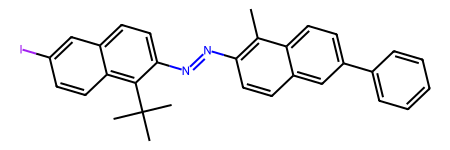

In [4]:
sub = Chem.MolFromSmiles('Cc1c(/N=N/c2ccc3cc(I)ccc3c2C(C)(C)C)ccc2cc(-c3ccccc3)ccc12')
#add_atom_numbers(sub)
sub

In [5]:
# Generate SMILES for substituents
# each element in the list is a tuple: (substituent, connecting atom index, bond type)

electron_withdrawing_substituents = [
    (Chem.MolFromSmiles('FC(F)F'), 1, rdchem.BondType.SINGLE),  # Trifluoromethyl
    (Chem.MolFromSmiles('Cl'), 0, rdchem.BondType.SINGLE),  # Chloro
    (Chem.MolFromSmiles('F'), 0, rdchem.BondType.SINGLE),  # Fluoro
    (Chem.MolFromSmiles('I'), 0, rdchem.BondType.SINGLE),  # Iodo
    (Chem.MolFromSmiles('Br'), 0, rdchem.BondType.SINGLE),  # Bromo
    (Chem.MolFromSmiles('C=O'), 0, rdchem.BondType.SINGLE),  # Carbonyl
    (Chem.MolFromSmiles('OC(=O)'), 1, rdchem.BondType.SINGLE),  # Carboxyl
    (Chem.MolFromSmiles('NC(=O)'), 1, rdchem.BondType.SINGLE),  # Amide
    (Chem.MolFromSmiles('C#N'), 0, rdchem.BondType.SINGLE),  # Cyano
    (Chem.MolFromSmiles('S(=O)(=O)O'), 0, rdchem.BondType.SINGLE),  # Sulfonic acid
    (Chem.MolFromSmiles('[N+](=O)[O-]'), 0, rdchem.BondType.SINGLE),  # Nitro
    (Chem.MolFromSmiles('C1=CNN=C1'), 2, rdchem.BondType.SINGLE),  # Pyrazole
]

electron_donating_substituents = [
    (Chem.MolFromSmiles('N'), 0, rdchem.BondType.SINGLE),  # Amino
    (Chem.MolFromSmiles('CO'), 1, rdchem.BondType.SINGLE),  # Methoxy
    (Chem.MolFromSmiles('O'), 0, rdchem.BondType.SINGLE),  # Hydroxy
    (Chem.MolFromSmiles('C'), 0, rdchem.BondType.SINGLE),  # Methyl
    (Chem.MolFromSmiles('CN'), 0, rdchem.BondType.SINGLE),  # Methylamine
    (Chem.MolFromSmiles('C1=CC=CC=C1'), 0, rdchem.BondType.SINGLE),  # Phenyl
]

electron_donating_rings = [
    (Chem.MolFromSmiles('C1=CC=C2C(=C1)C=CS2'),
     0, rdchem.BondType.SINGLE),  # Benzothiophene
    (Chem.MolFromSmiles('C1=COC=C1'), 0, rdchem.BondType.SINGLE),  # Furan
    (Chem.MolFromSmiles('C1=CSC=C1'), 0, rdchem.BondType.SINGLE),  # Thiophene
    (Chem.MolFromSmiles('C1=CNC=C1'), 0, rdchem.BondType.SINGLE),  # Pyrrole
    (Chem.MolFromSmiles('C1=CN=CN1'), 0, rdchem.BondType.SINGLE),  # Imidazole
    (Chem.MolFromSmiles('C1=CON=C1'), 0, rdchem.BondType.SINGLE),  # Isoxazole
    # Methoxy-substituted thiophene
    (Chem.MolFromSmiles('COc1cccs1'), 5, rdchem.BondType.SINGLE),
    # Amino-substituted thiophene
    (Chem.MolFromSmiles('NCc1cccs1'), 5, rdchem.BondType.SINGLE),
    (Chem.MolFromSmiles('c1cc[nH]c1'), 2, rdchem.BondType.SINGLE),  # Pyrrole
    (Chem.MolFromSmiles('c1cc[nH]c1'), 1, rdchem.BondType.SINGLE),  # Pyrrole
    # Methyl-substituted pyrazole
    (Chem.MolFromSmiles('Cc1cc(C)[nH]n1'), 2, rdchem.BondType.SINGLE),
    # Methyl-substituted isoxazole
    (Chem.MolFromSmiles('c1cc(C)on1'), 2, rdchem.BondType.SINGLE),
]

electron_withdrawing_rings = [
    (Chem.MolFromSmiles('C1=CC=NC=C1'), 0, rdchem.BondType.SINGLE),  # Pyridine
    (Chem.MolFromSmiles('C1=CNN=C1'), 0, rdchem.BondType.SINGLE),  # Pyrazole
    (Chem.MolFromSmiles('c2ccc(n1cccn1)nc2'), 6, rdchem.BondType.SINGLE),  # Pyrazole with nitrogen substituted phenyl
    (Chem.MolFromSmiles('Oc2cccc(c1cc[nH]n1)c2'), 8, rdchem.BondType.SINGLE),  # Pyrazole with phenol
    (Chem.MolFromSmiles('c2ccc1n[nH]cc1c2'), 0, rdchem.BondType.SINGLE),  # Pyrazole extended with benzene
]

steric_blocking_substituents = [
    (Chem.MolFromSmiles('C'), 0, rdchem.BondType.SINGLE),  # Methyl
    (Chem.MolFromSmiles('CC'), 0, rdchem.BondType.SINGLE),  # Ethyl
    (Chem.MolFromSmiles('C(C)C'), 0, rdchem.BondType.SINGLE),  # Isopropyl
    (Chem.MolFromSmiles('C(C)(C)C'), 0, rdchem.BondType.SINGLE),  # Tert-butyl
    (Chem.MolFromSmiles('FC(F)F'), 1, rdchem.BondType.SINGLE),  # Trifluoromethyl
    (Chem.MolFromSmiles('Cl'), 0, rdchem.BondType.SINGLE),  # Chloro
    (Chem.MolFromSmiles('F'), 0, rdchem.BondType.SINGLE),  # Fluoro
    (Chem.MolFromSmiles('I'), 0, rdchem.BondType.SINGLE),  # Iodo
    (Chem.MolFromSmiles('Br'), 0, rdchem.BondType.SINGLE),  # Bromo
]
# Validate substituent molecules
# invalid_substituent_EWG = validate_molecules(electron_withdrawing_substituents)
# print("Invalid EWG substituents:", invalid_substituent_EWG)
# 
# Validate substituent molecules
# invalid_substituent_EDG = validate_molecules(electron_donating_substituents)
# print("Invalid EDG substituents:", invalid_substituent_EDG)
# 
# Validate ring substituent molecules
# invalid_ring_sub_EDG = validate_molecules(electron_donating_rings)
# print("Invalid EDG rings:", invalid_ring_sub_EDG)
# 
# Validate ring substituent molecules
# invalid_ring_sub_EWG = validate_molecules(electron_withdrawing_rings)
# print("Invalid EWG rings:", invalid_ring_sub_EWG)

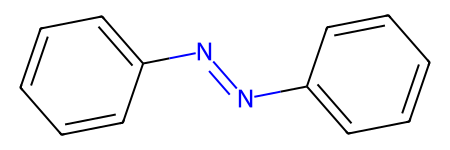

In [6]:
# Load the azobenzene structure
azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N/C2=CC=CC=C2')
#add_atom_numbers(azobenzene)
azobenzene



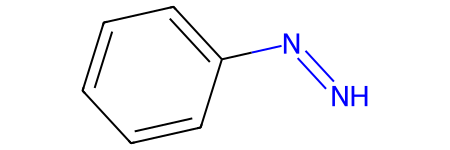

In [7]:
half_azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N')
# add_atom_numbers(half_azobenzene)
half_azobenzene

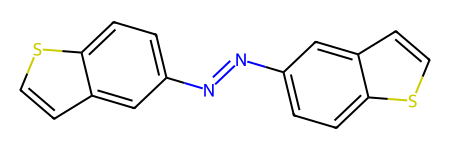

In [8]:
extened_azobenzene = Chem.MolFromSmiles("c1cc2cc(/N=N/c3ccc4sccc4c3)ccc2s1")
#add_atom_numbers(extened_azobenzene)
extened_azobenzene


In [9]:
# Generate azobenzene variations
azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N/C2=CC=CC=C2')
all_positions = [0, 1, 2, 4, 5, 9, 10, 11, 12, 13]

ortho_positions = [2, 4, 9, 13]
meta_positions = [1, 5, 10, 12]
para_positions = [0, 11]

left_ring = [0, 1, 2, 4, 5]
left_ring_meta = [1, 5]
left_ring_ortho = [2, 4]
left_ring_para = [0]

right_ring = [9, 10, 11, 12, 13]
right_ring_meta = [10, 12]
right_ring_ortho = [9, 13]
right_ring_para = [11]

all_new_molecules = MoleculeSet()
max_subs_para = 1
max_subs_ortho = 2
max_subs_meta = 2

logging.info('Generating push-pull azobenzene variations')

# Generate molecules with electron-donating substituents on the left ring
new_azobenzenes_meta = generate_and_print_molecules(
    azobenzene, electron_donating_substituents, left_ring_meta, max_subs_meta, 'left', 'meta')
new_azobenzenes_para = generate_and_print_molecules(
    azobenzene, electron_donating_substituents+electron_donating_rings, left_ring_para, max_subs_para, 'left', 'para')

# Generate molecules with electron-withdrawing substituents on the right ring
for new_azobenzene in new_azobenzenes_meta:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents+electron_withdrawing_rings, right_ring_para, max_subs_para, 'right', 'para'))

for new_azobenzene in new_azobenzenes_para:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents+electron_withdrawing_rings, right_ring_para, max_subs_para, 'right', 'para'))
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
logging.info('Generating azobenzene variations that hinder ts')

# Add substituents that destabilize the z isomer
steric_azobenzenes = generate_and_print_molecules(
    azobenzene, steric_blocking_substituents, ortho_positions, max_subs_ortho, 'both', 'ortho')

for new_steric_azobenzene_right in steric_azobenzenes:
    more_steric_azobenzenes_right = generate_molecules(
        new_steric_azobenzene_right, electron_withdrawing_substituents, right_ring_para, 1)
    for num_subs in range(0, 2):
        for new_azobenzene_left in more_steric_azobenzenes_right:
            more_steric_azobenzenes = generate_molecules(
                new_azobenzene_left, electron_donating_substituents, left_ring_para, num_subs)
            all_new_molecules.update_with_canonical_smiles(more_steric_azobenzenes)

# Generate half-azobenzene variations with the ring substituents
half_azobenzene = Chem.MolFromSmiles('C1=CC=C(C=C1)/N=N')
ring_sub_placement = [7]
ring_subs = electron_donating_rings + electron_withdrawing_rings
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
logging.info('Generating half-azobenzene variations with different rings')

half_azobenzenes_ring_subs = generate_molecules(
    half_azobenzene, ring_subs, ring_sub_placement, 1, min_subs=1)

# Expand each of the molecules with the ring substituent by adding up to three additional substituents at the sub placements
ring_positions = [0, 1, 2, 4, 5]
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
logging.info("Adding subs to the half-azobenzene variations")

for max_subs in range(0, 4):
    # Generate molecules with electron-donating substituents
    for mol in half_azobenzenes_ring_subs:
        all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
            mol, electron_donating_substituents, left_ring_meta, 2, 'half-azobenzene', 'electron-donating meta'))
        new_ortho = generate_and_print_molecules(
            mol, electron_donating_substituents, left_ring_ortho, 2, 'half-azobenzene', 'electron-donating ortho')
        all_new_molecules.update_with_canonical_smiles(new_ortho)
        for ortho_mol in new_ortho:
            added_para = generate_and_print_molecules(
                mol, electron_donating_substituents, left_ring_para, 1, 'half-azobenzene', 'electron-donating para')
            all_new_molecules.update_with_canonical_smiles(added_para)

    # Generate molecules with electron-withdrawing substituents
    for mol in half_azobenzenes_ring_subs:
        all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
            mol, electron_withdrawing_substituents, left_ring_meta, 2, 'half-azobenzene', 'electron-withdrawing meta'))
        new_ortho = generate_and_print_molecules(
            mol, electron_withdrawing_substituents, left_ring_ortho, 2, 'half-azobenzene', 'electron-withdrawing ortho')
        all_new_molecules.update_with_canonical_smiles(new_ortho)
        for ortho_mol in new_ortho:
            added_para = generate_and_print_molecules(
                mol, electron_withdrawing_substituents, left_ring_para, 1, 'half-azobenzene', 'electron-withdrawing para')
            all_new_molecules.update_with_canonical_smiles(added_para)

        
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")

INFO:root:Generating push-pull azobenzene variations
INFO:root:Generated a total of 4136 new molecules.
INFO:root:Generating azobenzene variations that hinder ts
INFO:root:Generated a total of 16934 new molecules.
INFO:root:Generating half-azobenzene variations with different rings
INFO:root:Generated a total of 16934 new molecules.
INFO:root:Adding subs to the half-azobenzene variations
INFO:root:Generated a total of 20324 new molecules.


In [10]:
ortho = [16, 3, 15, 8]

right_posistions = [9, 13, 12]
left_posisitons = [0, 1, 17]

# Example usage:
base_smiles = "c1cc2cc(/N=N/c3ccc4*ccc4c3)ccc2*1"
atom_list = ['S', 'O', 'N', 'C']
indices = [0, 1]  # Indices of the atoms to replace (indices of '*' in the base_smiles)
new_extended_azos = replace_atoms(base_smiles, atom_list, indices)


In [11]:
index = 1
# Generate molecules with electron-donating substituents
for mol in new_extended_azos:
    logging.info(f"molecule {index}/{len(new_extended_azos)}")
    added_ortho = generate_and_print_molecules(
                mol, steric_blocking_substituents, ortho, 2, 'extened azobenzene ortho', 'steric blocking left')        
    all_new_molecules.update_with_canonical_smiles(added_ortho)
    
    for subs_mol in added_ortho:
        with_subs_left = generate_and_print_molecules(
        mol, electron_donating_substituents, left_posisitons, 1, 'extended azobenzene', 'electron-donating subs')
        all_new_molecules.update_with_canonical_smiles(with_subs_left)
                
    
    # Generate molecules with electron-withdrawing substituents
        for left_subs_mol in with_subs_left:
            with_subs = generate_and_print_molecules(
                mol, electron_withdrawing_substituents, right_posistions, 1, 'extended azobenzene', 'electron-withdrawing subs')
        
            all_new_molecules.update_with_canonical_smiles(with_subs)
            

    index += 1

INFO:root:molecule 1/16
INFO:root:molecule 2/16
INFO:root:molecule 3/16
INFO:root:molecule 4/16
INFO:root:molecule 5/16
INFO:root:molecule 6/16
INFO:root:molecule 7/16
INFO:root:molecule 8/16
INFO:root:molecule 9/16
INFO:root:molecule 10/16
INFO:root:molecule 11/16
INFO:root:molecule 12/16
INFO:root:molecule 13/16
INFO:root:molecule 14/16
INFO:root:molecule 15/16
INFO:root:molecule 16/16


In [12]:
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")

INFO:root:Generated a total of 25362 new molecules.


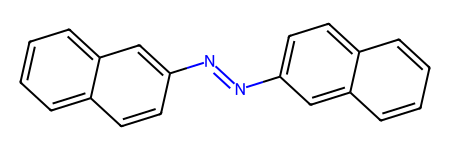

In [13]:
# Load the azobenzene structure
long_azobenzene = Chem.MolFromSmiles('c4ccc3cc(/N=N/c2ccc1ccccc1c2)ccc3c4')
# add_atom_numbers(long_azobenzene)
long_azobenzene

In [14]:
# Generate azobenzene variations
azobenzene = long_azobenzene


ortho_positions = [4, 18, 9, 17]
meta_positions = [2, 21, 19, 10, 12, 15]
para_positions = [0, 1, 13, 14]

left_ring = [0, 1, 4, 18, 2, 21, 19]
left_ring_meta = [2, 21]
left_ring_ortho = [4, 18]
left_ring_para = [0]

right_ring = [10, 12, 15, 13, 14, 9, 17]
right_ring_meta = [12, 15]
right_ring_ortho = [9, 17]
right_ring_para = [13]
max_subs_para = 1
max_subs_ortho = 2
max_subs_meta = 2

logging.info('Generating push-pull azobenzene variations')

# Generate molecules with electron-donating substituents on the left ring
long_azobenzenes_meta = generate_and_print_molecules(
    azobenzene, electron_donating_substituents, left_ring_meta, max_subs_meta, 'left', 'meta')
long_azobenzenes_para = generate_and_print_molecules(
    azobenzene, electron_donating_substituents, left_ring_para, max_subs_para, 'left', 'para')

# Generate molecules with electron-withdrawing substituents on the right ring
for new_azobenzene in long_azobenzenes_meta:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_para, max_subs_para, 'right', 'para'))

for new_azobenzene in long_azobenzenes_para:
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_meta, max_subs_meta, 'right', 'meta'))
    all_new_molecules.update_with_canonical_smiles(generate_and_print_molecules(
        new_azobenzene, electron_withdrawing_substituents, right_ring_para, max_subs_para, 'right', 'para'))
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")
logging.info('Generating azobenzene variations that hinder ts')

# Add substituents that destabilize the z isomer
steric_long_azobenzenes = generate_and_print_molecules(
    azobenzene, steric_blocking_substituents, ortho_positions, max_subs_ortho, 'both', 'ortho')

for new_steric_azobenzene_right in steric_long_azobenzenes:
    more_steric_azobenzenes_right = generate_molecules(
        new_steric_azobenzene_right, electron_withdrawing_substituents, right_ring_para, 1)
    for num_subs in range(0, 2):
        for new_azobenzene_left in more_steric_azobenzenes_right:
            more_steric_azobenzenes = generate_molecules(
                new_azobenzene_left, electron_donating_substituents, left_ring_para, num_subs)
            all_new_molecules.update_with_canonical_smiles(more_steric_azobenzenes)
logging.info(
    f"Generated a total of {len(all_new_molecules)} new molecules.")

INFO:root:Generating push-pull azobenzene variations
INFO:root:Generated a total of 29362 new molecules.
INFO:root:Generating azobenzene variations that hinder ts
INFO:root:Generated a total of 55030 new molecules.


In [16]:
input_df = pd.DataFrame(
    columns=['comp_name', 'smiles', 'charge', 'multiplicity'])

for smiles in tqdm(all_new_molecules.smiles()):
    comp_hash = get_hashed_label(smiles)
    comp_name = f"azo_{comp_hash}"
    charge = 0
    multiplicity = 1

    input_df = pd.concat([input_df, pd.DataFrame(
        [{'comp_name': comp_name, 'smiles': smiles, 'charge': charge, 'multiplicity': multiplicity}])], ignore_index=True)

# input_df['molecular_weight'] = input_df['smiles'].apply(
#     lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))

55030it [03:05, 296.89it/s]


print(f"Generated a total of {len(all_new_molecules_smiles)} new molecules.")


In [17]:
# save to csv
input_df.to_csv('molecules.csv', index=False)

In [4]:
input_df = pd.read_csv('molecules.csv')

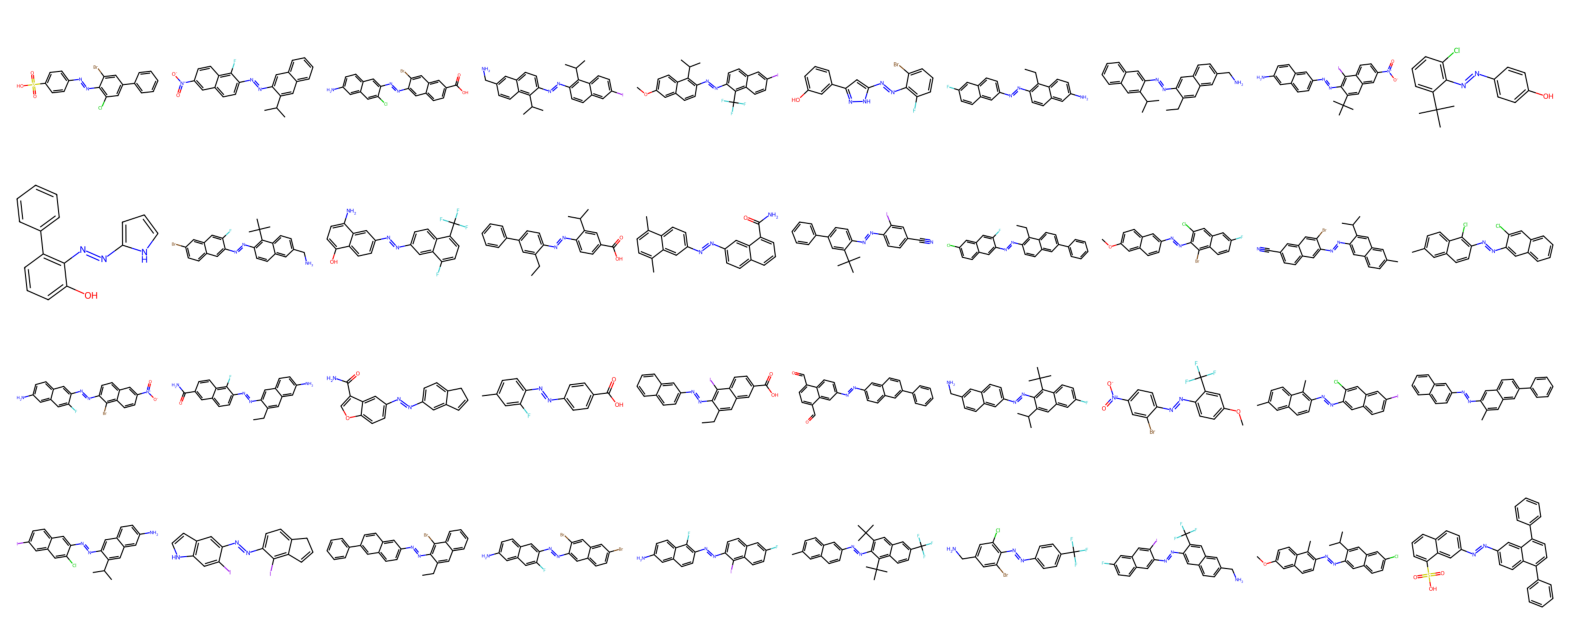

In [5]:
from PIL import Image

# Define the number of rows and the number of images
num_rows = 4
num_images = 40

# Select the specified number of random SMILES
random_mols_smiles = random.sample(list(input_df.smiles.values), k=num_images)
mols = [Chem.MolFromSmiles(smiles) for smiles in random_mols_smiles]

# Individual image size
img_size = (300, 300) # You can adjust these values

# Calculate the number of columns based on the number of images and rows
num_cols = num_images // num_rows

# Create a blank image to hold the grid
grid_img = Image.new('RGB', (img_size[0] * num_cols, img_size[1] * num_rows))

# Iterate through the molecules and paste them into the grid
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=img_size)
    row = i // num_cols
    col = i % num_cols
    grid_img.paste(img, (col * img_size[0], row * img_size[1]))

# Set the figure size (width, height) in inches
plt.figure(figsize=(20, 10)) # You can adjust these values

# Display the grid
plt.imshow(grid_img)
plt.axis('off')
plt.show()


Could not place image 55 after 1000 attempts. Canvas might be too crowded.
Could not place image 56 after 1000 attempts. Canvas might be too crowded.
Could not place image 58 after 1000 attempts. Canvas might be too crowded.
Could not place image 59 after 1000 attempts. Canvas might be too crowded.
Could not place image 60 after 1000 attempts. Canvas might be too crowded.
Could not place image 61 after 1000 attempts. Canvas might be too crowded.
Could not place image 62 after 1000 attempts. Canvas might be too crowded.
Could not place image 63 after 1000 attempts. Canvas might be too crowded.
Could not place image 64 after 1000 attempts. Canvas might be too crowded.
Could not place image 65 after 1000 attempts. Canvas might be too crowded.
Could not place image 66 after 1000 attempts. Canvas might be too crowded.
Could not place image 67 after 1000 attempts. Canvas might be too crowded.
Could not place image 68 after 1000 attempts. Canvas might be too crowded.
Could not place image 69 

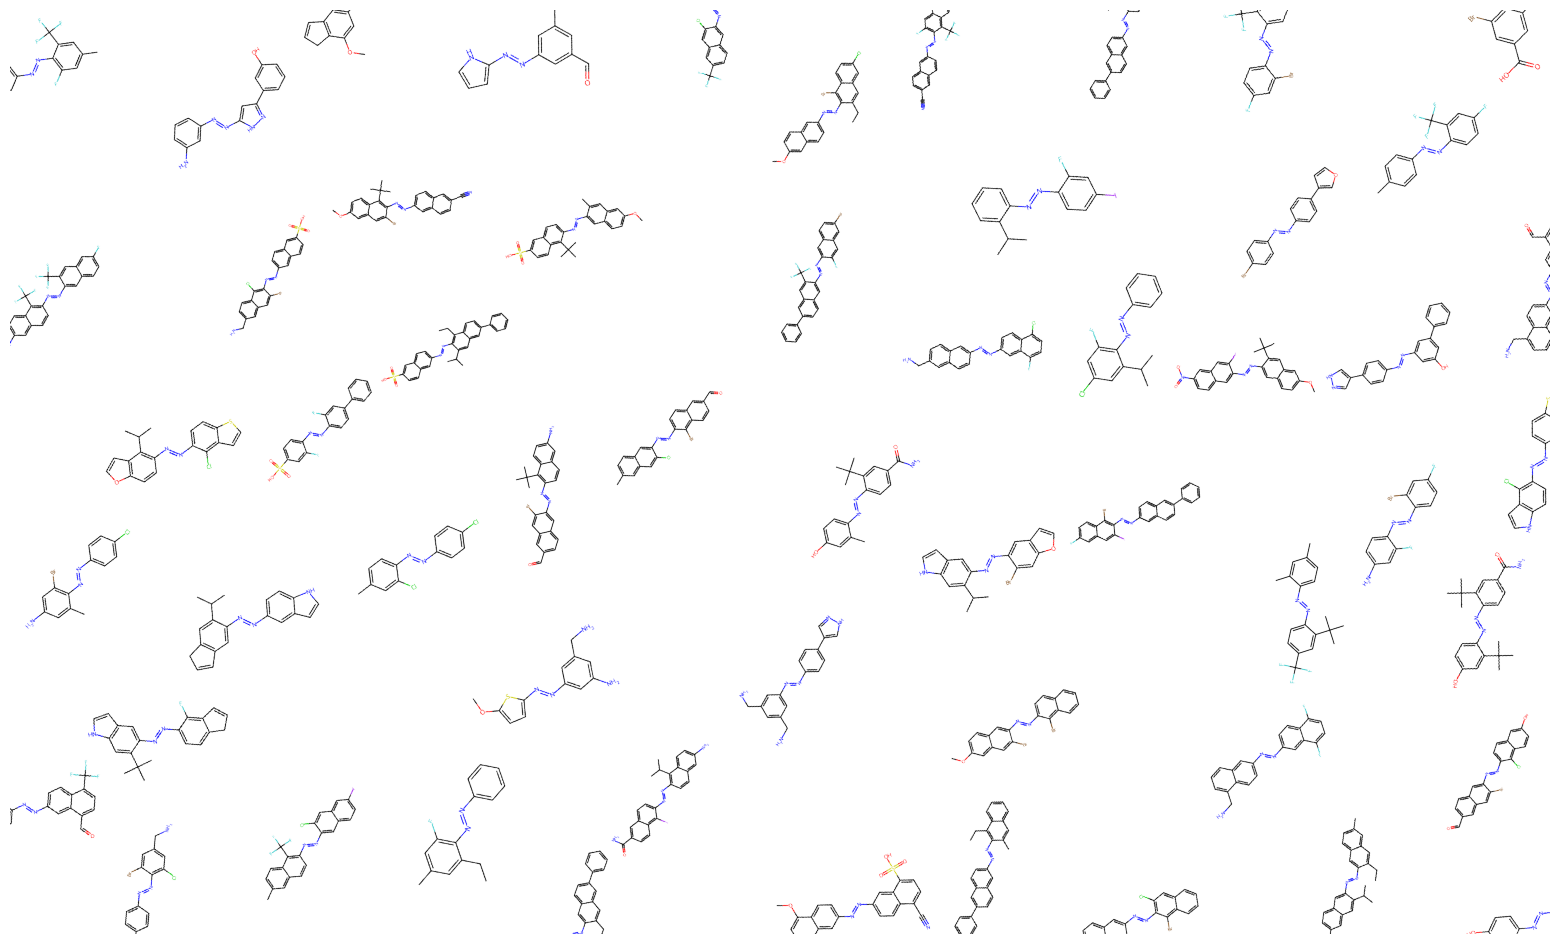

In [10]:
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

# Define the number of images
num_images = 100

# Select the specified number of random SMILES
random_mols_smiles = random.sample(list(input_df['smiles']), k=num_images)
mols = [Chem.MolFromSmiles(smiles) for smiles in random_mols_smiles]

# Canvas size
canvas_size = (3000, 1800)

# Individual image size
img_size = (300, 300)

# Create a blank image to hold the canvas with transparency
canvas_img = Image.new('RGBA', canvas_size, (255, 255, 255, 0))

# List to keep track of occupied coordinates
occupied_coords = []

# Function to check for overlap
def check_overlap(x, y, occupied_coords, img_size):
    for ox, oy, o_img_size in occupied_coords:
        overlap_x = min(x + img_size[0], ox + o_img_size[0]) - max(x, ox)
        overlap_y = min(y + img_size[1], oy + o_img_size[1]) - max(y, oy)
        
        if overlap_x > 0 and overlap_y > 0:
            if overlap_x * overlap_y > 0.25 * img_size[0] * img_size[1]:
                return True
    return False


# Maximum number of attempts to place an image
max_attempts = 1000

# Iterate through the molecules and paste them into random positions on the canvas
for i, mol in enumerate(mols):
    img = Draw.MolToImage(mol, size=img_size, transparent=True)
    img = img.convert("RGBA")
    datas = img.getdata()

    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    img.putdata(newData)

    # Add random rotation here, between 0 and 90 degrees
    angle = random.uniform(0, 90)
    img = img.rotate(angle, expand=True)

    attempts = 0
    while True:
        # Allow x and y to be negative or greater than canvas dimensions
        x = random.randint(-img.width // 2, canvas_size[0] - img.width // 2)
        y = random.randint(-img.height // 2, canvas_size[1] - img.height // 2)
        
        if not check_overlap(x, y, occupied_coords, (img.width, img.height)):
            break

        attempts += 1
        if attempts >= max_attempts:
            print(f"Could not place image {i+1} after {max_attempts} attempts. Canvas might be too crowded.")
            break

    if attempts < max_attempts:
        occupied_coords.append((x, y, (img.width, img.height)))
        canvas_img.paste(img, (x, y), img)

# Convert to NumPy array for Matplotlib
canvas_array = np.array(canvas_img)

# Set the figure size (width, height) in inches
plt.figure(figsize=(20, 12))

# Display the canvas
plt.imshow(canvas_array)
plt.axis('off')

# Save the figure in high resolution
plt.savefig('high_res_canvas.png', dpi=300)

plt.show()



In [23]:
# from rdkit import Chem
# from rdkit.Chem import Descriptors
# from rdkit.Chem import rdMolDescriptors
# import math
# import numpy as np

In [24]:
# def count_sulfurs(mol):
    # return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 16)
# 
# def count_electronegative_atoms(mol):
    # return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() in [7, 8, 9, 16, 17, 35])
# 
# def count_aromatic_rings(mol):
    # return sum(1 for ring in mol.GetRingInfo().AtomRings() if all(mol.GetAtomWithIdx(i).GetIsAromatic() for i in ring))
# 
# def calc_polarizability(mol):
    # return rdMolDescriptors.CalcTPSA(mol)
# 
# def count_larger_atoms(mol):
    # return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() > 6 and atom.GetAtomicNum() not in [18, 36, 54, 86])  # Count atoms with atomic number greater than 6, excluding noble gases
# 
# def find_extreme(df, col, method):
    # extreme_value = df[col].agg(method)
    # extreme_df = df[df[col] == extreme_value]
    # return extreme_df.sample(1)
# 

In [25]:
# df = pd.read_csv('molecules.csv')
# 
# Convert SMILES strings to RDKit Mol objects and add as a new column
# df['Mol'] = df['smiles'].apply(Chem.MolFromSmiles)
# 
# Calculate molecular weight
# df['MolecularWeight'] = df['Mol'].apply(Descriptors.MolWt)
# 
# Calculate the 5% and 95% quantiles for molecular weight
# low_mw_quantile = df['MolecularWeight'].quantile(0.05)
# high_mw_quantile = df['MolecularWeight'].quantile(0.95)
# 
# Filter the DataFrame to only include molecules in the top/bottom 5% for molecular weight
# low_mw_df = df[df['MolecularWeight'] <= low_mw_quantile]
# high_mw_df = df[df['MolecularWeight'] >= high_mw_quantile]
# 
# low_mw_df = low_mw_df.copy()
# high_mw_df = high_mw_df.copy()
# 
# for df_subset, subset_name in zip([low_mw_df, high_mw_df], ['low_mw_df', 'high_mw_df']):
    # df_subset['NumSulfurs'] = df_subset['Mol'].apply(count_sulfurs)
    # df_subset['NumElectronegativeAtoms'] = df_subset['Mol'].apply(count_electronegative_atoms)
    # df_subset['NumAromaticRings'] = df_subset['Mol'].apply(count_aromatic_rings)
    # df_subset['Polarizability'] = df_subset['Mol'].apply(calc_polarizability)
    # df_subset['NumLargerAtoms'] = df_subset['Mol'].apply(count_larger_atoms)
    # 
    # if subset_name == 'low_mw_df':
        # low_mw_df = df_subset
    # else:
        # high_mw_df = df_subset
# 
# chosen_molecules_df = pd.DataFrame(columns=['comp_name', 'smiles', 'charge', 'multiplicity'])
# 
# properties = ['NumSulfurs', 'NumLargerAtoms', 'NumElectronegativeAtoms', 'NumAromaticRings', 'Polarizability']
# chosen_molecules_list = []
# for prop in properties:
    # min_low = find_extreme(low_mw_df, prop, 'min')
    # max_low = find_extreme(low_mw_df, prop, 'max')
    # min_high = find_extreme(high_mw_df, prop, 'min')
    # max_high = find_extreme(high_mw_df, prop, 'max')
# 
    # chosen_molecules_list += [min_low[['comp_name', 'smiles', 'charge', 'multiplicity']], 
                        #  max_low[['comp_name', 'smiles', 'charge', 'multiplicity']], 
                        #  min_high[['comp_name', 'smiles', 'charge', 'multiplicity']], 
                        #  max_high[['comp_name', 'smiles', 'charge', 'multiplicity']]]
# 
    # print(f"For property {prop}:")
    # print(f"  - Min in low MW: {min_low['comp_name'].values[0]} (SMILES: {min_low['smiles'].values[0]}, Value: {min_low[prop].values[0]})")
    # print(f"  - Max in low MW: {max_low['comp_name'].values[0]} (SMILES: {max_low['smiles'].values[0]}, Value: {max_low[prop].values[0]})")
    # print(f"  - Min in high MW: {min_high['comp_name'].values[0]} (SMILES: {min_high['smiles'].values[0]}, Value: {min_high[prop].values[0]})")
    # print(f"  - Max in high MW: {max_high['comp_name'].values[0]} (SMILES: {max_high['smiles'].values[0]}, Value: {max_high[prop].values[0]})")
# 
# chosen_molecules_df = pd.concat(chosen_molecules_list, ignore_index=True)

For property NumSulfurs:
  - Min in low MW: azo_be679580ec (SMILES: NC(=O)c1cccc(C(N)=O)c1N=Nc1cnc[nH]1, Value: 0)
  - Max in low MW: azo_6e981440c4 (SMILES: NCc1ccc(N=Nc2cccc([N+](=O)[O-])c2)s1, Value: 1)
  - Min in high MW: azo_95c0909a42 (SMILES: Clc1cc2cc(Br)ccc2c(Br)c1/N=N/c1ccc2cc(-c3ccccc3)ccc2c1, Value: 0)
  - Max in high MW: azo_67bf8447ee (SMILES: Ic1c(/N=N/c2ccc3sccc3c2I)ccc2sccc12, Value: 2)
For property NumLargerAtoms:
  - Min in low MW: azo_d37c634f58 (SMILES: Cc1ccc(/N=N/c2ccccc2)cc1, Value: 2)
  - Max in low MW: azo_a942805b66 (SMILES: O=[N+]([O-])c1cccc([N+](=O)[O-])c1N=Nc1cnoc1, Value: 10)
  - Min in high MW: azo_52a65d561f (SMILES: Cc1c(/N=N/c2ccc3cc(I)ccc3c2C(C)(C)C)ccc2cc(-c3ccccc3)ccc12, Value: 3)
  - Max in high MW: azo_670ea8d68f (SMILES: O=S(=O)(O)c1ccc2cc(/N=N/c3ccc4cc(-c5ccccc5)ccc4c3C(F)(F)F)c(C(F)(F)F)cc2c1, Value: 12)
For property NumElectronegativeAtoms:
  - Min in low MW: azo_d929569792 (SMILES: Cc1cccc(C(C)(C)C)c1/N=N/c1ccccc1, Value: 2)
  - Max in low 

In [27]:
# chosen_molecules_df.to_csv('new_inp.csv', index=False)